In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from chinese_calendar import is_workday, is_holiday
import chinese_calendar as calendar
import time, datetime
from numba import jit
import warnings
warnings.filterwarnings('ignore')

In [2]:
text = pd.read_csv("PRSA_data.csv").convert_dtypes()

In [3]:
#preprocess:

#1.feature genertating
#
# text['time'] = text.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
# text = text.set_index('time')


#北风强度值
def transform_north(x):
    if(x.cbwd=='NE' or x.cbwd=='NW'):
        return x.Iws
    else: return 0

text['N_E'] = text.apply(lambda x: transform_north(x),axis=1 )


def transform_four_period(x):
    if(0<=x and x<=6): return 'night'
    elif(x<=12): return 'morning'
    elif(x<=18): return 'afternoon'
    else :return 'evening'
text['period'] = text.apply(lambda x: transform_four_period(x.hour),axis=1 )

#spring, summer, fall, winter

def transform_four_season(x):
    if(3<=x and x<=5): return 'spring'
    elif(x<=8): return 'summer'
    elif(x<=10): return 'fall'
    else :return 'winter'
text['season'] = text.apply(lambda x: transform_four_season(x.month),axis=1 )

#the week (weekdays, weekends, or holidays)
def transform_four_Week(year,month,day):
    now_date = datetime.date(year, month, day)
    on_holiday, holiday_name = calendar.get_holiday_detail(now_date)
    if(on_holiday): return 'weekends' if holiday_name is None else 'holiday'
    elif(is_workday(now_date)):return 'workday'
    else: return 'weekends'
text['Week'] = text.apply(lambda x: transform_four_Week(x.year,x.month,x.day),axis=1 )



def norm_to_float(c):
    element = text[c].unique()
    dictionary = dict(zip(element,range(0,len(element)))) #反转
    text[c] = text.apply(lambda x:dictionary[x[c]],axis=1)
    return dictionary
dict_period = norm_to_float('period')
dict_season = norm_to_float('season')
dict_Week = norm_to_float('Week')
# dict_PM2_5 = norm_to_float('pm2.5')





def transform_four_segment(x):
    if(8<=x and x<=9): return 'Morning_rush '
    elif(x<=17): return 'Work'
    elif(x<=19): return 'Evening_rush'
    else :return 'Home'
text['segment'] = text.apply(lambda x: transform_four_period(x.hour),axis=1 )
dict_Segment = norm_to_float('segment')


text['diff'] = text['DEWP']-text['N_E']

from sklearn.decomposition import PCA
pca  = PCA(n_components=1)
text['composition'] = pca.fit_transform(list(zip(text['DEWP'],-text['N_E'])))



text['cbwd'].unique()
text = text.join(pd.get_dummies(text['cbwd']).astype('float'))
del text['cbwd']

#2.processing the missing value
#from the segment3 ,this is the best choice :fill with mean
#We using the text to fillin to simplify ; The right way is to fill in with Train_set
text=text.fillna(int(text['pm2.5'].mean()))

In [4]:

#time period of the day (e.g, morning, afternoon, evening, night)
def generate_dataset(data):
    #先划分数据集
    Train_set=pd.DataFrame(columns=text.columns)
    Test_set=pd.DataFrame(columns=text.columns)
    text_data =data.groupby(['year','month','day'])
    for index,(name,data)  in enumerate(text_data):
        if((index+1)%7 ==0):
            Test_set =Test_set.append(data)
        else:
            Train_set = Train_set.append(data)

    return Train_set,Test_set
Train_set,Test_set = generate_dataset(text)

In [5]:

from sklearn.utils import shuffle
Train_set = shuffle(Train_set)
Test_set = shuffle(Test_set)
X_train = Train_set.astype('float')
Y_train  = X_train.pop('pm2.5')
X_test =Test_set.astype('float')
Y_test =X_test.pop('pm2.5')

[06:25:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

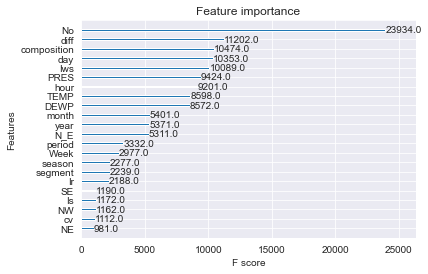

In [6]:
from xgboost import XGBClassifier,XGBRegressor
#XGBoosting
model = XGBRegressor(
    objective='reg:linear',
    colsample_bytree=0.3,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=5000,
    alpha=10
)
model.fit(X_train,Y_train)
score = model.score(X_test,Y_test)
import xgboost as xgb
xgb.plot_importance(model)

In [7]:
score
#在没有调节参数之前的模型正确率

0.7352129630389658

In [13]:
from sklearn.model_selection import GridSearchCV

#调节思路优先调节n_estimators，影响最大
cv_params = {'n_estimators': [500, 1500, 3600, 7700, 10000]}
params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
          'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = xgb.XGBRegressor(**params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, Y_train)

#param_grid={'n_estimators': [400, 500, 600, 700, 800]},scoring='r2', verbose=1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

In [ ]:
#调节和booster相关参数
#max_depth and min_child_weight
v_params = {'max_depth': [3, 4, 5, 6, 7], 'min_child_weight': [1, 2, 3]}
params = {'learning_rate': 0.1, 'n_estimators': 550, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
          'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
cv_params = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
params = {'learning_rate': 0.1, 'n_estimators': 550, 'max_depth': 4, 'min_child_weight': 5, 'seed': 0,
          'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

In [ ]:
#learning rate
cv_params = {'learning_rate': [0.01, 0.05, 0.07]}
params = {'learning_rate': 0.1, 'n_estimators': 550, 'max_depth': 4, 'min_child_weight': 5, 'seed': 0,
          'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 1, 'reg_lambda': 1}
